In [41]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.stats.mstats import mquantiles
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Generate Random df following MetaData given, for testing - Delete before Handing In

In [34]:
# Set a seed for reproducibility
np.random.seed(42)

# Number of rows in the random DataFrame
num_rows = 10000

# Define the date range: start at 2009-01-01, end at 2011-12-31
start_date = datetime(2009, 1, 1)
end_date = datetime(2011, 12, 31)
delta_days = (end_date - start_date).days

# Generate random order dates between 2009-01-01 and 2011-12-31
order_dates = [start_date + timedelta(days=np.random.randint(0, delta_days + 1)) for _ in range(num_rows)]

# For "Requested Delivery Date", assume it's generally after the order date
requested_delivery_dates = [
    od + timedelta(days=np.random.randint(1,30)) for od in order_dates
]

# Country Codes (example)
country_codes = ['US', 'DE', 'FR', 'UK', 'IT', 'ES', 'CN', 'JP', 'IN', 'BR']
customer_country_codes = np.random.choice(country_codes, size=num_rows)

# Generate 25 unique product codes
def random_product_code(length=6):
    return ''.join(np.random.choice(list(string.ascii_uppercase + string.digits), length))

unique_product_codes = [random_product_code() for _ in range(5)]
product_codes = np.random.choice(unique_product_codes, size=num_rows)

# Description (generic short descriptions)
descriptions_list = ["Widget A", "Widget B", "Gadget C", "Gizmo D", "Tool E", "Part F"]
descriptions = np.random.choice(descriptions_list, size=num_rows)

# Order type always "VO"
order_types = ["VO"] * num_rows

# Customer Order Code
unique_order_count = 300  # how many unique orders
unique_order_codes = [f"ORD{str(i).zfill(5)}" for i in range(1, unique_order_count+1)]
customer_order_codes = np.random.choice(unique_order_codes, size=num_rows)

# Value (random float values)
values = np.round(np.random.uniform(10, 1000, size=num_rows), 2)

# Currency (example)
currencies = ["USD", "EUR", "GBP", "JPY", "CNY"]
currency_codes = np.random.choice(currencies, size=num_rows)

# Items (quantity)
items = np.random.randint(1, 100, size=num_rows)

# Route (simulate by combining country code with a random region code)
routes = [f"{cc}-{np.random.randint(1,10)}" for cc in customer_country_codes]

# Create the DataFrame
df = pd.DataFrame({
    "Order Date": [d.strftime("%d.%m.%Y") for d in order_dates],
    "Requested Delivery Date": [d.strftime("%d.%m.%Y") for d in requested_delivery_dates],
    "Customer Country Code": customer_country_codes,
    "Product Code": product_codes,
    "Description": descriptions,
    "Order type": order_types,
    "Customer Order Code": customer_order_codes,
    "Value": values,
    "Currency": currency_codes,
    "Items": items,
    "Route": routes
})

print(df.head())
print("Number of unique product codes:", df["Product Code"].nunique())

   Order Date Requested Delivery Date Customer Country Code Product Code  \
0  11.05.2011              05.06.2011                    CN       ULFFDI   
1  11.11.2011              08.12.2011                    DE       ZIIAGP   
2  02.05.2009              24.05.2009                    UK       PH7F37   
3  12.04.2010              29.04.2010                    US       ZIIAGP   
4  27.11.2009              01.12.2009                    IT       ULFFDI   

  Description Order type Customer Order Code   Value Currency  Items Route  
0    Widget B         VO            ORD00204  724.50      CNY     13  CN-9  
1     Gizmo D         VO            ORD00238  654.83      GBP     45  DE-2  
2    Gadget C         VO            ORD00294  886.97      CNY      9  UK-4  
3    Widget B         VO            ORD00184  191.64      JPY     99  US-6  
4      Part F         VO            ORD00212  742.39      USD     28  IT-4  
Number of unique product codes: 5


# Import & Explore DF on Exam Day

In [ ]:
df = pd.read_csv('')

# 1. How many Distinct Orders Are Received Each Month

In [35]:
# Convert the "Order Date" column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')

# Create separate columns for Year and Month
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month

# Now group by Year and Month and count distinct Customer Order Codes
monthly_order_counts = (
    df.groupby(['Year', 'Month'])['Customer Order Code']
    .nunique()
    .reset_index(name='Distinct Order Count')
)

# Create a nicely formatted Year-Month column
monthly_order_counts['Year-Month'] = monthly_order_counts.apply(
    lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1
)

print(monthly_order_counts)

    Year  Month  Distinct Order Count Year-Month
0   2009      1                   183    2009-01
1   2009      2                   157    2009-02
2   2009      3                   170    2009-03
3   2009      4                   174    2009-04
4   2009      5                   199    2009-05
5   2009      6                   176    2009-06
6   2009      7                   182    2009-07
7   2009      8                   184    2009-08
8   2009      9                   173    2009-09
9   2009     10                   164    2009-10
10  2009     11                   170    2009-11
11  2009     12                   174    2009-12
12  2010      1                   192    2010-01
13  2010      2                   179    2010-02
14  2010      3                   177    2010-03
15  2010      4                   176    2010-04
16  2010      5                   179    2010-05
17  2010      6                   186    2010-06
18  2010      7                   183    2010-07
19  2010      8     

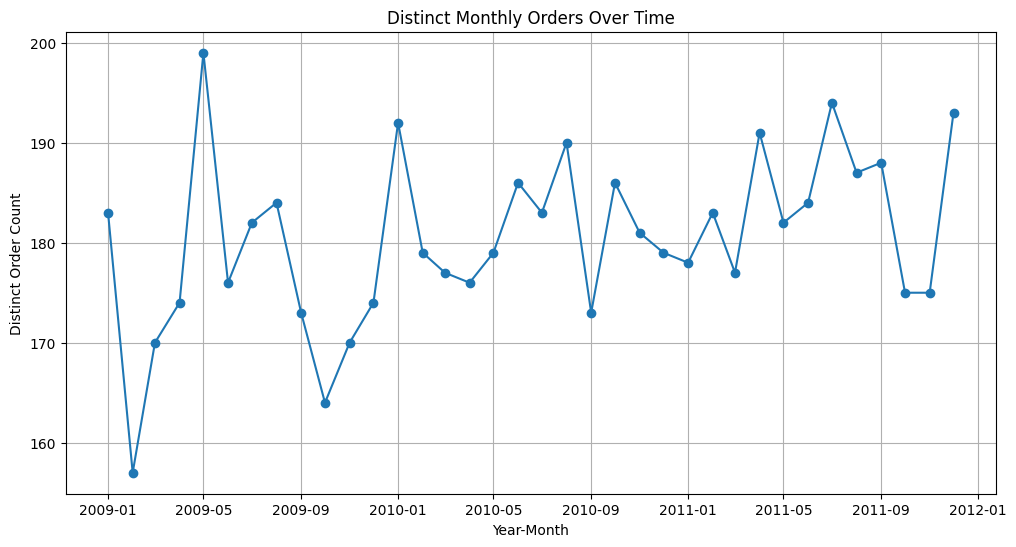

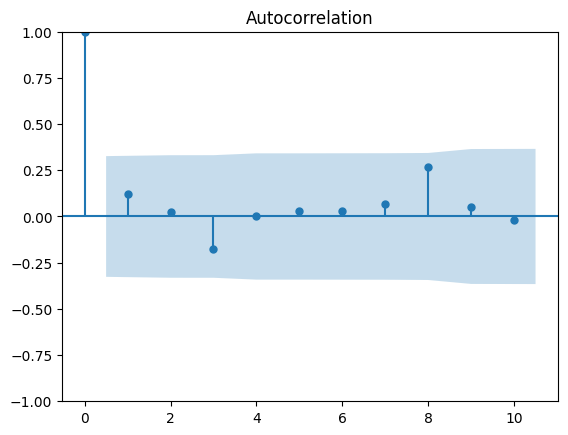

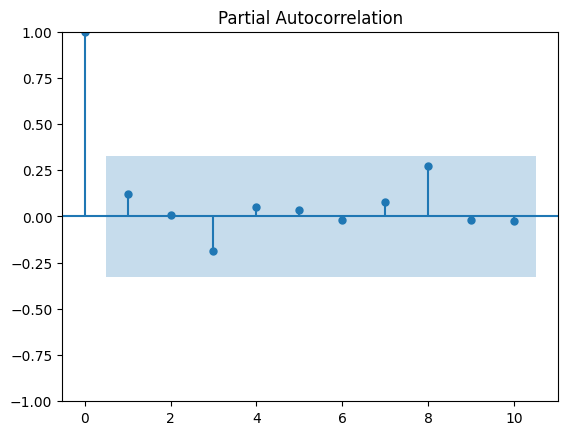

Best SARIMA order: (0, 0, 0) Seasonal order: (0, 1, 2, 12) with AIC: 6.0
                                   SARIMAX Results                                   
Dep. Variable:          Distinct Order Count   No. Observations:                   36
Model:             SARIMAX(0, 1, [1, 2], 12)   Log Likelihood                   0.000
Date:                       Sat, 07 Dec 2024   AIC                              6.000
Time:                               18:13:00   BIC                                nan
Sample:                           01-01-2009   HQIC                               nan
                                - 12-01-2011                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12            0         -0        nan        nan           0           0
ma

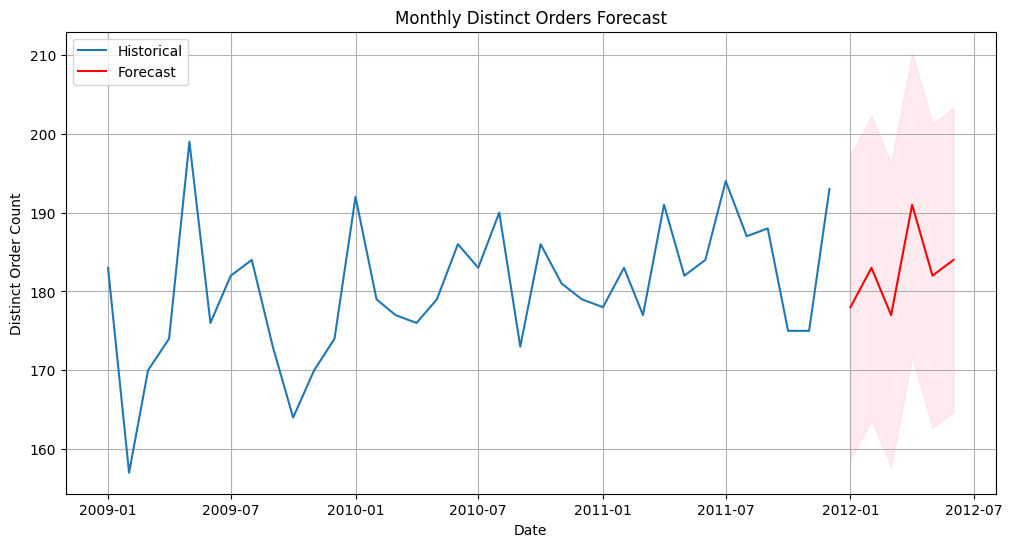

In [36]:
def prepare_monthly_time_series(df):
    # Ensure "Order Date" is datetime
    if df['Order Date'].dtype != 'datetime64[ns]':
        df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y', errors='coerce')
    
    # If "Year" and "Month" not in df, create them
    if 'Year' not in df.columns:
        df['Year'] = df['Order Date'].dt.year
    if 'Month' not in df.columns:
        df['Month'] = df['Order Date'].dt.month
    
    # Compute distinct order counts by Year-Month
    monthly_order_counts = (
        df.groupby(['Year', 'Month'])['Customer Order Code']
        .nunique()
        .reset_index(name='Distinct Order Count')
    )

    # Create Year-Month column if not present
    if 'Year-Month' not in monthly_order_counts.columns:
        monthly_order_counts['Year-Month'] = monthly_order_counts.apply(
            lambda row: f"{row['Year']}-{row['Month']:02d}", axis=1
        )
    
    # Convert "Year-Month" to datetime and set as index
    if monthly_order_counts.index.name != 'Year-Month':
        if not pd.api.types.is_datetime64_any_dtype(monthly_order_counts['Year-Month']):
            monthly_order_counts['Year-Month'] = pd.to_datetime(monthly_order_counts['Year-Month'], format='%Y-%m')
        monthly_order_counts.set_index('Year-Month', inplace=True)
    
    # Sort by index
    monthly_order_counts.sort_index(inplace=True)

    # Ensure monthly frequency
    time_series = monthly_order_counts['Distinct Order Count'].asfreq('MS')

    return time_series


def find_best_sarima_model(time_series,
                           p_values=range(0,3),
                           d_values=range(0,3),
                           q_values=range(0,3),
                           P_values=range(0,3),
                           D_values=range(0,2),
                           Q_values=range(0,3),
                           s_values=[6, 12]):  
    """
    This function does a brute-force grid search over given parameters for
    SARIMAX to find the best model based on AIC.
    
    Parameters:
    - time_series: pandas Series indexed by date
    - p_values, d_values, q_values: Ranges for the non-seasonal ARIMA parameters
    - P_values, D_values, Q_values, s_values: Ranges for seasonal ARIMA parameters and seasonal period
      For monthly data, s=12 might be common for yearly seasonality, 
      but you can try smaller or larger values.
    """
    best_aic = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    warnings.filterwarnings("ignore")
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for s in s_values:
                                # Avoid models that are trivially large compared to dataset size
                                # But here we try anyway
                                try:
                                    model = sm.tsa.statespace.SARIMAX(
                                        time_series.dropna(),
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False
                                    )
                                    results = model.fit(disp=False)
                                    if results.aic < best_aic:
                                        best_aic = results.aic
                                        best_order = (p, d, q)
                                        best_seasonal_order = (P, D, Q, s)
                                        best_model = results
                                except:
                                    continue
    return best_order, best_seasonal_order, best_aic, best_model


# Assuming df is your original DataFrame with "Order Date" and "Customer Order Code"
time_series = prepare_monthly_time_series(df)

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, marker='o')
plt.title('Distinct Monthly Orders Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Distinct Order Count')
plt.grid(True)
plt.show()

# If time series is too short, reduce lags accordingly
lags = min(len(time_series.dropna())//2, 10)

sm.graphics.tsa.plot_acf(time_series.dropna(), lags=lags)
plt.show()

sm.graphics.tsa.plot_pacf(time_series.dropna(), lags=lags)
plt.show()

# Search for the best SARIMAX model
best_order, best_seasonal_order, best_aic, best_model = find_best_sarima_model(
    time_series,
    p_values=range(0,3),
    d_values=range(0,3),
    q_values=range(0,3),
    P_values=range(0,3),
    D_values=range(0,2),
    Q_values=range(0,3),
    s_values=[6, 12] # Testing a semi-annual and annual seasonality for a small dataset
)

print(f"Best SARIMA order: {best_order} Seasonal order: {best_seasonal_order} with AIC: {best_aic}")
print(best_model.summary())

# Forecast
steps_ahead = 6
forecast_res = best_model.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

print("Forecasted Distinct Orders:")
print(forecast_mean)
print("\nConfidence Intervals:")
print(forecast_ci)

# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series.values, label='Historical')
future_index = pd.date_range(start=time_series.index[-1] + pd.offsets.MonthBegin(), periods=steps_ahead, freq='MS')
plt.plot(future_index, forecast_mean.values, label='Forecast', color='red')
plt.fill_between(future_index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('Monthly Distinct Orders Forecast')
plt.xlabel('Date')
plt.ylabel('Distinct Order Count')
plt.legend()
plt.grid(True)
plt.show()


# 2. Which items are demanded (Classification Model)

In [37]:
# 1. Prepare the dataset
# Ensure Order Date is a datetime
if df['Order Date'].dtype != 'datetime64[ns]':
    df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y', errors='coerce')

# Extract month
df['Month'] = df['Order Date'].dt.month

# Define a function to map month to season (example: Northern Hemisphere)
# You can adjust this mapping as needed
def month_to_season(m):
    # Simple example: Dec-Feb = Winter, Mar-May = Spring, Jun-Aug = Summer, Sep-Nov = Autumn
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(month_to_season)

# The target is "Product Code"
y = df['Product Code']

# Select features 
# Let's pick Season, Customer Country Code as features.
# Encode categorical variables using one-hot encoding
categorical_features = ['Season', 'Customer Country Code', 'Route']
numeric_features = ['Items']

# It’s often a good idea to ensure no missing values. Fill or drop them as needed.
df[categorical_features] = df[categorical_features].fillna('Unknown')
df[numeric_features] = df[numeric_features].fillna(0)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# Combine numeric and encoded categorical features
X = pd.concat([df[numeric_features], df_encoded], axis=1)

# Remove rows with missing product codes if any
X = X[y.notna()]
y = y[y.notna()]

# 2. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # If stratify is possible test stratify=y

class_names = list(y_test.unique())  # Replace y_test with y_train if needed

# 3. Fit a multinomial logistic regression model
model_classification = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial', solver='lbfgs')
model_classification.fit(X_train, y_train)

# 4. Make predictions
predictions = model_classification.predict(X_test)

# 5. Evaluate the model using F1-score (weighted average since multi-class)
f1 = f1_score(y_test, predictions, average='weighted')
print("F1-Score of the multinomial logistic regression model:", f1)

# Print the classification report
report = classification_report(y_test, predictions, target_names=class_names)
print("Classification Report:")
print(report)


F1-Score of the multinomial logistic regression model: 0.19969379909740934
Classification Report:
              precision    recall  f1-score   support

      KY2SR2       0.21      0.17      0.19       386
      ZIIAGP       0.20      0.23      0.21       389
      7KZA3R       0.20      0.21      0.21       401
      PH7F37       0.23      0.23      0.23       408
      ULFFDI       0.16      0.16      0.16       416

    accuracy                           0.20      2000
   macro avg       0.20      0.20      0.20      2000
weighted avg       0.20      0.20      0.20      2000



# 3. Quantity Demanded

In [ ]:
############################################
# STEP A: Monthly distinct order count forecast (already done previously)
############################################

# monthly_order_counts: DataFrame with historical monthly distinct orders indexed by Year-Month
# best_model: fitted ARIMA/SARIMA model from previous steps

steps_ahead = 5  # Forecast Months
forecast_res = best_model.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean

monthly_forecasts = pd.DataFrame({
    'Year-Month': forecast_mean.index,
    'Predicted_Order_Count': forecast_mean.values
}).set_index('Year-Month')

print("Monthly Forecasts:")
print(monthly_forecasts)

############################################
# STEP B: Classification (choice) model (already trained)
############################################

# model_classification: Your trained multinomial logistic regression model
# X_train: The training DataFrame used to fit model_classification
# feature_cols: The columns used as features when training model_classification
# Ensure model_classification and X_train are defined and available

known_feature_cols = X_train.columns
product_classes = model_classification.classes_

############################################
# Simulating Future Orders
############################################

def month_to_season(m):
    # Adjust as needed based on your definition of seasons
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

def simulate_future_orders_for_month(year_month, n_orders, historical_feature_distributions, known_feature_cols):
    month = year_month.month
    season = month_to_season(month)

    # Create a base DataFrame with minimal features
    simulated_orders = pd.DataFrame()
    simulated_orders['Month'] = [month] * n_orders
    simulated_orders['Season'] = [season] * n_orders

    # Sample categorical features from historical distributions
    # Example structure of historical_feature_distributions:
    # {
    #   'Customer Country Code': {'US':0.3, 'DE':0.2, 'FR':0.5},
    #   'Currency': {'USD':0.5, 'EUR':0.5},
    #   'Route': {'US-1':0.3, 'DE-2':0.3, 'FR-4':0.4},
    #   'Order type': {'VO':1.0}
    # }

    for cat_feat, dist in historical_feature_distributions.items():
        categories = list(dist.keys())
        probs = list(dist.values())
        simulated_orders[cat_feat] = np.random.choice(categories, size=n_orders, p=probs)

    # Simulate numeric features (e.g., Items, Value)
    # Here we just pick random values. For a real scenario, use real distributions/stats.
    simulated_orders['Items'] = np.random.randint(1, 50, size=n_orders)
    simulated_orders['Value'] = np.round(np.random.uniform(10, 300, n_orders), 2)

    # One-hot encode categorical variables as done in training
    simulated_encoded = pd.get_dummies(simulated_orders, drop_first=True)

    # Add missing columns if necessary
    for col in known_feature_cols:
        if col not in simulated_encoded.columns:
            simulated_encoded[col] = 0

    # Ensure columns are in the same order as X_train
    simulated_encoded = simulated_encoded[known_feature_cols]

    return simulated_encoded

# Example historical distributions (Replace with real ones from your dataset)
historical_feature_distributions = {
    'Customer Country Code': {'US':0.3, 'DE':0.3, 'FR':0.4},  # Example
    'Currency': {'USD':0.5, 'EUR':0.5},                     # Example
    'Route': {'US-1':0.4, 'DE-2':0.3, 'FR-4':0.3},          # Example
    'Order type': {'VO':1.0}                                # If only one type, all are VO
}

############################################
# Combine Steps A and B to Forecast Product-Level Demand
############################################

all_future_predictions = []

for future_month, row in monthly_forecasts.iterrows():
    predicted_order_count = int(row['Predicted_Order_Count'])

    # Simulate future orders for that month
    simulated_orders_for_month = simulate_future_orders_for_month(
        future_month, predicted_order_count, historical_feature_distributions, known_feature_cols
    )

    # Get product choice probabilities
    product_probabilities = model_classification.predict_proba(simulated_orders_for_month)

    # Sum probabilities to get expected counts
    expected_counts = product_probabilities.sum(axis=0)
    monthly_product_forecast = pd.DataFrame({
        'Product': product_classes,
        'Expected_Count': expected_counts
    })
    monthly_product_forecast['Year-Month'] = future_month
    all_future_predictions.append(monthly_product_forecast)

final_forecast = pd.concat(all_future_predictions, ignore_index=True)

print("Final Consolidated Forecast (Expected Product Counts by Month):")
print(final_forecast)


Monthly Forecasts:
            Predicted_Order_Count
Year-Month                       
2012-01-01                  178.0
2012-02-01                  183.0
2012-03-01                  177.0
2012-04-01                  191.0
2012-05-01                  182.0
Final Consolidated Forecast (Expected Product Counts by Month):
   Product  Expected_Count Year-Month
0   7KZA3R       37.834230 2012-01-01
1   KY2SR2       34.512595 2012-01-01
2   PH7F37       37.327823 2012-01-01
3   ULFFDI       31.109820 2012-01-01
4   ZIIAGP       37.215533 2012-01-01
5   7KZA3R       39.560782 2012-02-01
6   KY2SR2       35.226098 2012-02-01
7   PH7F37       38.303792 2012-02-01
8   ULFFDI       31.890295 2012-02-01
9   ZIIAGP       38.019032 2012-02-01
10  7KZA3R       39.117700 2012-03-01
11  KY2SR2       33.680099 2012-03-01
12  PH7F37       37.349115 2012-03-01
13  ULFFDI       30.401774 2012-03-01
14  ZIIAGP       36.451312 2012-03-01
15  7KZA3R       40.492370 2012-04-01
16  KY2SR2       37.091106 2012-0

Using his Quantile Method:

In [40]:
# 1. Compute quantiles per product to characterize the distribution of quantities
product_quantiles = {}
quantile_levels = [0.1, 0.25, 0.5, 0.75, 0.9]  # example quantiles

for product, group in df.groupby('Product Code'):
    # Extract the historical items ordered for this product
    product_items = group['Items'].values
    # Compute quantiles
    q_values = mquantiles(product_items, prob=quantile_levels)
    product_quantiles[product] = {
        'quantile_levels': quantile_levels,
        'quantile_values': q_values
    }

# At this point, product_quantiles is a dictionary:
# product_quantiles = {
#   'PROD123': {
#       'quantile_levels': [0.1,0.25,0.5,0.75,0.9],
#       'quantile_values': [q10, q25, q50, q75, q90]
#   },
#   ...
# }

# 2. After combining Steps A & B, you have a `final_forecast` DataFrame:
# final_forecast columns: ['Year-Month', 'Product', 'Expected_Count']
# The Expected_Count is how many times we expect each product to be chosen in that month.

# Now we simulate actual quantities demanded per product, per month.
# Let's say we create a new DataFrame with simulated quantities:
final_forecast_with_quantities = []

for idx, row in final_forecast.iterrows():
    product = row['Product']
    month = row['Year-Month']
    expected_count = int(round(row['Expected_Count']))
    
    if expected_count <= 0:
        # If no expected orders, move on
        continue
    
    # Retrieve product quantiles
    if product in product_quantiles:
        q_data = product_quantiles[product]
        q_levels = q_data['quantile_levels']
        q_values = q_data['quantile_values']
        
        # 3. Simulate quantities for each of the expected orders of this product.
        # For example, we draw a random number from Uniform(0,1) for each order
        # and use it to interpolate the quantity from our quantiles.
        
        # We'll use a simple approach: if u < 0.1, assign q10; if u <0.25, q25, etc.
        # You could also do linear interpolation if desired.
        
        simulated_quantities = []
        for _ in range(expected_count):
            u = np.random.rand()  # random draw from Uniform(0,1)
            # Find which quantile bucket u falls into
            for i, ql in enumerate(q_levels):
                if u < ql:
                    simulated_quantities.append(int(np.round(q_values[i])))
                    break
            else:
                # If not broken from loop, u >= last quantile level,
                # assign the highest quantile
                simulated_quantities.append(int(np.round(q_values[-1])))
        
        # Aggregate the simulated quantities to get total quantity demanded
        total_quantity = sum(simulated_quantities)
        
        final_forecast_with_quantities.append({
            'Year-Month': month,
            'Product': product,
            'Expected_Count': expected_count,
            'Total_Quantity_Demanded': total_quantity,
            'Average_Quantity_per_Order': total_quantity / expected_count if expected_count > 0 else 0
        })
    else:
        # If we have no historical quantiles for this product (unlikely if product was in historical data),
        # we can default to a mean or a fixed value
        avg_items = df.loc[df['Product Code'] == product, 'Items'].mean()
        total_quantity = avg_items * expected_count
        final_forecast_with_quantities.append({
            'Year-Month': month,
            'Product': product,
            'Expected_Count': expected_count,
            'Total_Quantity_Demanded': total_quantity,
            'Average_Quantity_per_Order': avg_items
        })

final_forecast_with_quantities = pd.DataFrame(final_forecast_with_quantities)

print(final_forecast_with_quantities)

   Year-Month Product  Expected_Count  Total_Quantity_Demanded  \
0  2012-01-01  7KZA3R              38                     2437   
1  2012-01-01  KY2SR2              35                     2145   
2  2012-01-01  PH7F37              37                     2361   
3  2012-01-01  ULFFDI              31                     1856   
4  2012-01-01  ZIIAGP              37                     2143   
5  2012-02-01  7KZA3R              40                     2093   
6  2012-02-01  KY2SR2              35                     2023   
7  2012-02-01  PH7F37              38                     1922   
8  2012-02-01  ULFFDI              32                     1916   
9  2012-02-01  ZIIAGP              38                     2370   
10 2012-03-01  7KZA3R              39                     2774   
11 2012-03-01  KY2SR2              34                     1698   
12 2012-03-01  PH7F37              37                     1963   
13 2012-03-01  ULFFDI              30                     1882   
14 2012-03

# 4. Calculate Lead Time - Quantiles Method

In [42]:
############################################
# Step 1: Compute Historical Lead Times
############################################
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y', errors='coerce')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y', errors='coerce')

# Compute lead time in days
df['Lead Time'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days

# Filter out non-positive lead times if they don't make sense in your context
df = df[df['Lead Time'] > 0]

############################################
# Step 2: Compute Lead Time Quantiles per Product
############################################
lead_time_quantiles = {}
quantile_levels = [0.1, 0.25, 0.5, 0.75, 0.9]

for product, group in df.groupby('Product Code'):
    product_lead_times = group['Lead Time'].values
    # Compute quantiles for lead time
    q_values = mquantiles(product_lead_times, prob=quantile_levels)
    lead_time_quantiles[product] = {
        'quantile_levels': quantile_levels,
        'quantile_values': q_values
    }

############################################
# Step 3: Simulate Lead Times for the Forecasted Products
# 
# We have final_forecast_with_quantities DataFrame with columns:
# ['Year-Month', 'Product', 'Expected_Count', 'Total_Quantity_Demanded', 'Average_Quantity_per_Order']
#
# For each product in final_forecast_with_quantities, we will simulate the lead times
# of those orders using the quantile distributions.
############################################

final_forecast_with_lead_times = []

for idx, row in final_forecast_with_quantities.iterrows():
    product = row['Product']
    expected_count = row['Expected_Count']
    month = row['Year-Month']

    if expected_count <= 0:
        # No orders expected, skip
        continue

    if product in lead_time_quantiles:
        q_data = lead_time_quantiles[product]
        q_levels = q_data['quantile_levels']
        q_values = q_data['quantile_values']

        # Simulate lead times for each expected order
        simulated_lead_times = []
        for _ in range(expected_count):
            u = np.random.rand()  # random draw from Uniform(0,1)
            # Determine which quantile bucket u falls into
            for i, ql in enumerate(q_levels):
                if u < ql:
                    simulated_lead_times.append(int(np.round(q_values[i])))
                    break
            else:
                # If u >= last quantile level, assign the highest quantile lead time
                simulated_lead_times.append(int(np.round(q_values[-1])))

        total_lead_time = sum(simulated_lead_times)
        average_lead_time = total_lead_time / expected_count

        # Add lead time info to the forecast
        record = row.to_dict()
        record['Average_Lead_Time'] = average_lead_time
        record['Total_Lead_Time'] = total_lead_time
        final_forecast_with_lead_times.append(record)
    else:
        # If no lead time quantiles for this product, fallback to mean lead time
        avg_lead = df.loc[df['Product Code'] == product, 'Lead Time'].mean()
        total_lead_time = avg_lead * expected_count

        record = row.to_dict()
        record['Average_Lead_Time'] = avg_lead
        record['Total_Lead_Time'] = total_lead_time
        final_forecast_with_lead_times.append(record)

final_forecast_with_lead_times = pd.DataFrame(final_forecast_with_lead_times)

print(final_forecast_with_lead_times)

   Year-Month Product  Expected_Count  Total_Quantity_Demanded  \
0  2012-01-01  7KZA3R              38                     2437   
1  2012-01-01  KY2SR2              35                     2145   
2  2012-01-01  PH7F37              37                     2361   
3  2012-01-01  ULFFDI              31                     1856   
4  2012-01-01  ZIIAGP              37                     2143   
5  2012-02-01  7KZA3R              40                     2093   
6  2012-02-01  KY2SR2              35                     2023   
7  2012-02-01  PH7F37              38                     1922   
8  2012-02-01  ULFFDI              32                     1916   
9  2012-02-01  ZIIAGP              38                     2370   
10 2012-03-01  7KZA3R              39                     2774   
11 2012-03-01  KY2SR2              34                     1698   
12 2012-03-01  PH7F37              37                     1963   
13 2012-03-01  ULFFDI              30                     1882   
14 2012-03

# 5. Consolidate All Models and Predict Demand, Report MAPE (Compare to 5month forecast to 2 month forecast with Monte Carlo Sims)

In [44]:
# --------------------------------------------
# Parameters
# --------------------------------------------
num_simulations = 100
quantile_levels = [0.1, 0.25, 0.5, 0.75, 0.9]

# --------------------------------------------
# Assume df is your full dataset (2009–2011)
# --------------------------------------------
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y', errors='coerce')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y', errors='coerce')

# Train on all data up to 2011-07-31 and test on last 5 months of 2011
train_df = df[(df['Order Date'] >= '2009-01-01') & (df['Order Date'] < '2011-08-01')].copy()
test_df = df[(df['Order Date'] >= '2011-08-01') & (df['Order Date'] <= '2011-12-31')].copy()

# --------------------------------------------
# Step A: Forecast Monthly Distinct Orders (Time Series)
# --------------------------------------------
train_df['Year'] = train_df['Order Date'].dt.year
train_df['Month'] = train_df['Order Date'].dt.month

monthly_train = (train_df.groupby(['Year','Month'])['Customer Order Code']
                 .nunique()
                 .reset_index(name='Distinct_Order_Count'))

monthly_train['Year-Month'] = pd.to_datetime(monthly_train['Year'].astype(str) + '-' +
                                            monthly_train['Month'].astype(str) + '-01')
monthly_train.set_index('Year-Month', inplace=True)
monthly_train.sort_index(inplace=True)
ts_train = monthly_train['Distinct_Order_Count'].asfreq('MS')

model = SARIMAX(ts_train.dropna(),
                order=(1,1,1),
                seasonal_order=(1,1,1,12),
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit()

# Forecast last 5 months of 2011
steps_ahead = 5  # now we only forecast Aug-Dec 2011
forecast_res = res.get_forecast(steps=steps_ahead)
forecast_mean = forecast_res.predicted_mean

monthly_forecasts = pd.DataFrame({
    'Year-Month': forecast_mean.index,
    'Predicted_Order_Count': forecast_mean.values
}).set_index('Year-Month')

def month_to_season(m):
    if m in [12,1,2]:
        return 'Winter'
    elif m in [3,4,5]:
        return 'Spring'
    elif m in [6,7,8]:
        return 'Summer'
    else:
        return 'Autumn'

# --------------------------------------------
# Step B: Classification Model for Product Choice
# --------------------------------------------
train_df['Month'] = train_df['Order Date'].dt.month
train_df['Season'] = train_df['Month'].apply(month_to_season)

categorical_features = ['Season','Customer Country Code','Currency','Route','Order type']
numeric_features = ['Items','Value']

train_df[categorical_features] = train_df[categorical_features].fillna('Unknown')
train_df[numeric_features] = train_df[numeric_features].fillna(0)

train_encoded = pd.get_dummies(train_df[categorical_features], drop_first=True)
X_train = pd.concat([train_df[numeric_features], train_encoded], axis=1)
y_train = train_df['Product Code']

model_classification = LogisticRegression(random_state=0, solver='lbfgs', max_iter=2000)
model_classification.fit(X_train, y_train)

product_classes = model_classification.classes_
known_feature_cols = X_train.columns

# --------------------------------------------
# Step C: Compute Quantiles for Quantity and Lead Time
# --------------------------------------------
product_quantiles = {}
for product, group in train_df.groupby('Product Code'):
    product_items = group['Items'].values
    q_values = mquantiles(product_items, prob=quantile_levels)
    product_quantiles[product] = {
        'quantile_levels': quantile_levels,
        'quantile_values': q_values
    }

train_df['Lead Time'] = (train_df['Requested Delivery Date'] - train_df['Order Date']).dt.days
train_df = train_df[train_df['Lead Time'] > 0]
lead_time_quantiles = {}
for product, group in train_df.groupby('Product Code'):
    product_lead_times = group['Lead Time'].values
    if len(product_lead_times) > 0:
        q_values = mquantiles(product_lead_times, prob=quantile_levels)
        lead_time_quantiles[product] = {
            'quantile_levels': quantile_levels,
            'quantile_values': q_values
        }

historical_feature_distributions = {
    'Customer Country Code': train_df['Customer Country Code'].value_counts(normalize=True).to_dict(),
    'Currency': train_df['Currency'].value_counts(normalize=True).to_dict(),
    'Route': train_df['Route'].value_counts(normalize=True).to_dict(),
    'Order type': train_df['Order type'].value_counts(normalize=True).to_dict()
}

def simulate_future_orders_for_month(year_month, n_orders, distributions, known_feature_cols):
    month = year_month.month
    season = month_to_season(month)

    simulated_orders = pd.DataFrame()
    simulated_orders['Month'] = [month]*n_orders
    simulated_orders['Season'] = [season]*n_orders

    for cat_feat, dist in distributions.items():
        cats = list(dist.keys())
        probs = list(dist.values())
        simulated_orders[cat_feat] = np.random.choice(cats, size=n_orders, p=probs)

    simulated_orders['Items'] = np.random.randint(1,50,size=n_orders)
    simulated_orders['Value'] = np.round(np.random.uniform(10,300,n_orders),2)

    simulated_encoded = pd.get_dummies(simulated_orders, drop_first=True)
    for col in known_feature_cols:
        if col not in simulated_encoded.columns:
            simulated_encoded[col] = 0
    simulated_encoded = simulated_encoded[known_feature_cols]
    return simulated_encoded

def simulate_forecast_and_compute_mape(forecast_horizon):
    # Re-run the SARIMAX with the desired horizon
    # Actually, we have already fitted the model on the train set.
    # Just get a new forecast for 'forecast_horizon' months.
    new_forecast_res = res.get_forecast(steps=forecast_horizon)
    new_forecast_mean = new_forecast_res.predicted_mean
    new_monthly_forecasts = pd.DataFrame({
        'Year-Month': new_forecast_mean.index,
        'Predicted_Order_Count': new_forecast_mean.values
    }).set_index('Year-Month')

    final_forecast = []
    for future_month, row in new_monthly_forecasts.iterrows():
        predicted_order_count = int(round(row['Predicted_Order_Count']))
        if predicted_order_count <= 0:
            continue
        simulated_orders_for_month = simulate_future_orders_for_month(future_month, predicted_order_count,
                                                                      historical_feature_distributions, known_feature_cols)
        product_prob = model_classification.predict_proba(simulated_orders_for_month)
        expected_counts = product_prob.sum(axis=0)
        monthly_product_forecast = pd.DataFrame({
            'Year-Month': future_month,
            'Product': product_classes,
            'Expected_Count': expected_counts
        })
        final_forecast.append(monthly_product_forecast)

    if len(final_forecast) == 0:
        return None

    final_forecast = pd.concat(final_forecast, ignore_index=True)

    # Simulate quantities and lead times
    final_forecast_with_quantities = []
    for idx, row in final_forecast.iterrows():
        product = row['Product']
        month = row['Year-Month']
        expected_count = int(round(row['Expected_Count']))

        if expected_count <= 0:
            continue

        # Quantity
        if product in product_quantiles:
            q_data = product_quantiles[product]
            q_levels = q_data['quantile_levels']
            q_values = q_data['quantile_values']
            simulated_quantities = []
            for _ in range(expected_count):
                u = np.random.rand()
                for i, ql in enumerate(q_levels):
                    if u < ql:
                        simulated_quantities.append(int(np.round(q_values[i])))
                        break
                else:
                    simulated_quantities.append(int(np.round(q_values[-1])))
            total_quantity = sum(simulated_quantities)
        else:
            avg_items = train_df.loc[train_df['Product Code']==product,'Items'].mean()
            total_quantity = avg_items * expected_count

        # Lead time
        if product in lead_time_quantiles:
            lt_data = lead_time_quantiles[product]
            lt_levels = lt_data['quantile_levels']
            lt_values = lt_data['quantile_values']
            simulated_lead_times = []
            for _ in range(expected_count):
                u = np.random.rand()
                for i, ql in enumerate(lt_levels):
                    if u < ql:
                        simulated_lead_times.append(int(np.round(lt_values[i])))
                        break
                else:
                    simulated_lead_times.append(int(np.round(lt_values[-1])))
            total_lead_time = sum(simulated_lead_times)
            avg_lead_time = total_lead_time / expected_count
        else:
            avg_lead = train_df.loc[train_df['Product Code']==product, 'Lead Time'].mean()
            total_lead_time = avg_lead * expected_count
            avg_lead_time = avg_lead

        final_forecast_with_quantities.append({
            'Year-Month': month,
            'Product': product,
            'Expected_Count': expected_count,
            'Total_Quantity_Demanded': total_quantity,
            'Average_Quantity_per_Order': total_quantity/expected_count if expected_count>0 else 0,
            'Average_Lead_Time': avg_lead_time,
            'Total_Lead_Time': total_lead_time
        })

    final_forecast_with_quantities = pd.DataFrame(final_forecast_with_quantities)
    if final_forecast_with_quantities.empty:
        return None

    # Compute MAPE on test data
    # Test data is last 5 months of 2011 (Aug-Dec) for the 5-month scenario
    # For the 2-month scenario, we still use the same test set (Aug-Dec) for evaluation, or
    # you could define a shorter test period. Here we keep it consistent.
    test_df['Year'] = test_df['Order Date'].dt.year
    test_df['Month'] = test_df['Order Date'].dt.month

    test_monthly_actual = (test_df.groupby(['Year','Month','Product Code'])['Items']
                           .sum()
                           .reset_index())
    test_monthly_actual['Year-Month'] = pd.to_datetime(test_monthly_actual['Year'].astype(str)+'-'
                                                      +test_monthly_actual['Month'].astype(str)+'-01')
    test_monthly_actual.rename(columns={'Product Code':'Product','Items':'Actual_Total_Quantity'}, inplace=True)

    final_forecast_with_quantities.set_index(['Year-Month','Product'], inplace=True)
    test_monthly_actual.set_index(['Year-Month','Product'], inplace=True)

    comparison_df = final_forecast_with_quantities.join(test_monthly_actual, how='inner')
    comparison_df.reset_index(inplace=True)

    comparison_df = comparison_df[comparison_df['Actual_Total_Quantity'] > 0]
    if comparison_df.empty:
        return None

    comparison_df['APE'] = np.abs((comparison_df['Actual_Total_Quantity'] - comparison_df['Total_Quantity_Demanded'])
                                  / comparison_df['Actual_Total_Quantity'])*100
    mape = comparison_df['APE'].mean()
    return mape

# Compute MAPE for the 5-month horizon scenario (no Monte Carlo, just one run)
mape_5_month = simulate_forecast_and_compute_mape(5)
print("MAPE with 5-month horizon:", mape_5_month, "%")

# Monte Carlo simulations for reducing to 2-month horizon
mapes_2_month = []
for _ in range(num_simulations):
    m = simulate_forecast_and_compute_mape(2)
    if m is not None:
        mapes_2_month.append(m)

if mapes_2_month:
    mean_mape_2 = np.mean(mapes_2_month)
    std_mape_2 = np.std(mapes_2_month)
    print(f"After reducing the horizon to 2 months and running {num_simulations} simulations:")
    print("Mean MAPE (2-month horizon):", mean_mape_2, "%")
    print("Std Dev of MAPE (2-month horizon):", std_mape_2, "%")
else:
    print("No MAPE computed for 2-month horizon simulations.")

MAPE with 5-month horizon: 24.480266781582422 %
After reducing the horizon to 2 months and running 100 simulations:
Mean MAPE (2-month horizon): 24.26404268414838 %
Std Dev of MAPE (2-month horizon): 1.6770515391406675 %
